Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
!gdown --id 1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs

Downloading...
From: https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs
To: /content/CNN_assignment.zip
824MB [00:07, 109MB/s] 


In [ ]:
pwd

'/content'

In [ ]:
!unzip /content/CNN_assignment.zip -d /content/dir

Archive:  /content/CNN_assignment.zip
  inflating: /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: /content/dir/Skin cancer ISIC The Inter

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


*italicized text*

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds= tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, validation_split=0.2, subset="training", image_size=(img_height,img_width), batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, validation_split=0.2, subset="validation", image_size=(img_height,img_width),batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
val_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize = (15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break;

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Normalizing

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.07859463 0.8259804


### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here

num_classes = 9

model1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [ ]:
model1

### Train the model

In [ ]:
epochs = 30
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 48s 845ms/step - loss: 1.9644 - accuracy: 0.2773 - val_loss: 1.7367 - val_accuracy: 0.4228
Epoch 2/30
56/56 [==============================] - 45s 812ms/step - loss: 1.6560 - accuracy: 0.4124 - val_loss: 1.5219 - val_accuracy: 0.5011
Epoch 3/30
56/56 [==============================] - 46s 816ms/step - loss: 1.4554 - accuracy: 0.4927 - val_loss: 1.4224 - val_accuracy: 0.5414
Epoch 4/30
56/56 [==============================] - 46s 827ms/step - loss: 1.3518 - accuracy: 0.5206 - val_loss: 1.4898 - val_accuracy: 0.5190
Epoch 5/30
56/56 [==============================] - 47s 832ms/step - loss: 1.2547 - accuracy: 0.5686 - val_loss: 1.6380 - val_accuracy: 0.4810
Epoch 6/30
56/56 [==============================] - 47s 838ms/step - loss: 1.1896 - accuracy: 0.5798 - val_loss: 1.3794 - val_accuracy: 0.5660
Epoch 7/30
56/56 [==============================] - 47s 834ms/step - loss: 1.1361 - accuracy: 0.5943 - val_loss: 1.5278 - val_accuracy: 0.4922

### Visualizing training results

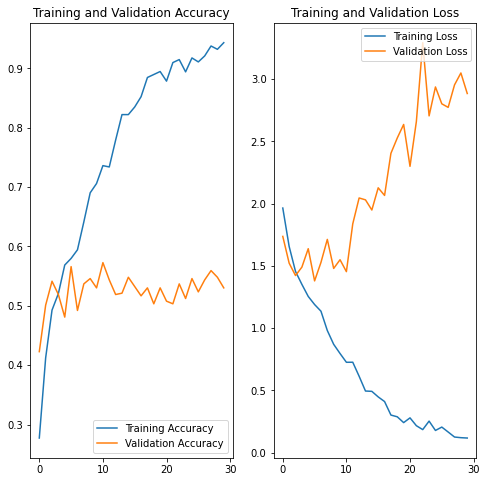

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

*italicized text*### Write your findings here

> Indented block
Observations
training accuracy: 94.21% and test accuracy: 59.85%
Possible case of overfitting
we will add dropouts



In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

num_classes = 9

model2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.45),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.45),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

epochs = 30
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 49s 871ms/step - loss: 0.9188 - accuracy: 0.6780 - val_loss: 1.3261 - val_accuracy: 0.5884
Epoch 2/30
56/56 [==============================] - 49s 876ms/step - loss: 0.8530 - accuracy: 0.6920 - val_loss: 1.4010 - val_accuracy: 0.5570
Epoch 3/30
56/56 [==============================] - 48s 854ms/step - loss: 0.8280 - accuracy: 0.6875 - val_loss: 1.4436 - val_accuracy: 0.5593
Epoch 4/30
56/56 [==============================] - 47s 847ms/step - loss: 0.8091 - accuracy: 0.7121 - val_loss: 1.3567 - val_accuracy: 0.5794
Epoch 5/30
56/56 [==============================] - 49s 869ms/step - loss: 0.7753 - accuracy: 0.7076 - val_loss: 1.5124 - val_accuracy: 0.5928
Epoch 6/30
56/56 [==============================] - 49s 874ms/step - loss: 0.7451 - accuracy: 0.7210 - val_loss: 1.4824 - val_accuracy: 0.5593
Epoch 7/30
56/56 [==============================] - 49s 869ms/step - loss: 0.7138 - accuracy: 0.7394 - val_loss: 1.8206 - val_accuracy: 0.5302

### Compiling the model

In [ ]:
## Your code goes here
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
## history = ## your training code
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 50s 885ms/step - loss: 0.3945 - accuracy: 0.8410 - val_loss: 1.9211 - val_accuracy: 0.5705
Epoch 2/20
56/56 [==============================] - 50s 894ms/step - loss: 0.3739 - accuracy: 0.8544 - val_loss: 1.8943 - val_accuracy: 0.5660
Epoch 3/20
56/56 [==============================] - 49s 881ms/step - loss: 0.3624 - accuracy: 0.8577 - val_loss: 2.6132 - val_accuracy: 0.5615
Epoch 4/20
56/56 [==============================] - 49s 870ms/step - loss: 0.3606 - accuracy: 0.8538 - val_loss: 2.5973 - val_accuracy: 0.5817
Epoch 5/20
56/56 [==============================] - 49s 876ms/step - loss: 0.3641 - accuracy: 0.8493 - val_loss: 2.3738 - val_accuracy: 0.5794
Epoch 6/20
56/56 [==============================] - 50s 892ms/step - loss: 0.3495 - accuracy: 0.8544 - val_loss: 2.3466 - val_accuracy: 0.5772
Epoch 7/20
56/56 [==============================] - 49s 870ms/step - loss: 0.3847 - accuracy: 0.8421 - val_loss: 2.7213 - val_accuracy: 0.5078

### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
arr=[]
fol=[]
tot=0
directory=os.listdir('/content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
for each in directory:
    currentFolder = '/content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/' + each
    i=0
    for i, file in enumerate(os.listdir(currentFolder)[0:]):
      i=i+1
    print("{} has {} images".format(each,i))
    arr.append(i)
    fol.append(each)
    tot=tot+i

pigmented benign keratosis has 462 images
dermatofibroma has 95 images
actinic keratosis has 114 images
seborrheic keratosis has 77 images
basal cell carcinoma has 376 images
nevus has 357 images
squamous cell carcinoma has 181 images
vascular lesion has 139 images
melanoma has 438 images


In [ ]:
dicts = {}
categories = fol
objects = arr
dicts = {key: value for key, value in zip(categories, objects)}
print(dicts)

{'pigmented benign keratosis': 462, 'dermatofibroma': 95, 'actinic keratosis': 114, 'seborrheic keratosis': 77, 'basal cell carcinoma': 376, 'nevus': 357, 'squamous cell carcinoma': 181, 'vascular lesion': 139, 'melanoma': 438}


In [ ]:
plt.figure(figsize=[25,6])
plt.bar(range(len(dicts)), objects, tick_label=categories)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

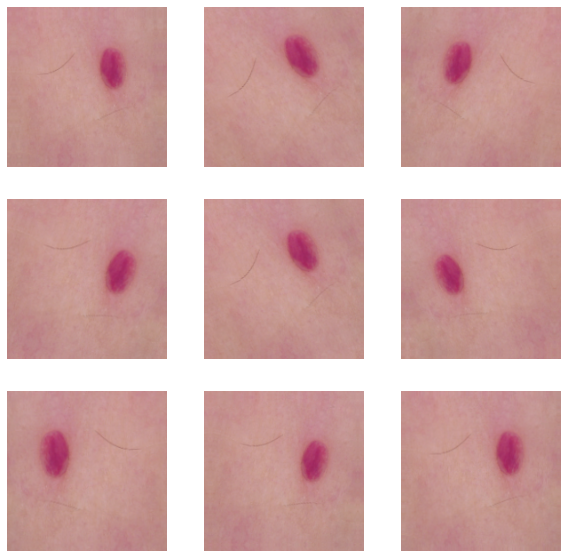

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model3 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
epochs = 30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 59s 1s/step - loss: 2.0117 - accuracy: 0.2472 - val_loss: 1.9324 - val_accuracy: 0.3110
Epoch 2/30
56/56 [==============================] - 57s 1s/step - loss: 1.7763 - accuracy: 0.3532 - val_loss: 1.5907 - val_accuracy: 0.4474
Epoch 3/30
56/56 [==============================] - 58s 1s/step - loss: 1.6492 - accuracy: 0.3979 - val_loss: 1.5668 - val_accuracy: 0.4497
Epoch 4/30
56/56 [==============================] - 57s 1s/step - loss: 1.5740 - accuracy: 0.4286 - val_loss: 1.4819 - val_accuracy: 0.5101
Epoch 5/30
56/56 [==============================] - 57s 1s/step - loss: 1.4932 - accuracy: 0.4715 - val_loss: 1.4518 - val_accuracy: 0.5101
Epoch 6/30
56/56 [==============================] - 57s 1s/step - loss: 1.4452 - accuracy: 0.5011 - val_loss: 1.4672 - val_accuracy: 0.5168
Epoch 7/30
56/56 [==============================] - 56s 1s/step - loss: 1.3808 - accuracy: 0.5167 - val_loss: 1.3893 - val_accuracy: 0.5369
Epoch 8/30
56/56 [==

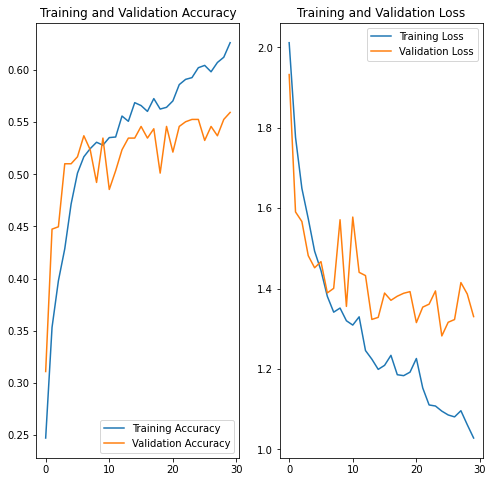

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F994F07EB10>: 100%|██████████| 500/500 [00:17<00:00, 28.29 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F994FC0B0D0>: 100%|██████████| 500/500 [00:17<00:00, 28.55 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9957952190>: 100%|██████████| 500/500 [00:17<00:00, 27.97 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F994F01FFD0>: 100%|██████████| 500/500 [01:20<00:00,  6.23 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F99579524D0>: 100%|██████████| 500/500 [01:25<00:00,  5.83 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F994F1381D0>: 100%|██████████| 500/500 [00:16<00:00, 30.22 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9956C8BA90>: 100%|██████████| 500/500 [00:41<00:00, 11.99 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F994FBF6550>: 100%|██████████| 500/500 [00:17<00:00, 29.24 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F99565BF8D0>: 100%|██████████| 500/500 [00:17<00:00, 28.74 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
from glob import glob

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024851.jpg_5c2cc951-2c93-45b3-a778-bb0a699374ab.jpg',
 '/content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024947.jpg_93c6642c-8534-43ff-af62-2b28be95f6eb.jpg',
 '/content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024635.jpg_7d0b1ac5-f38b-4ab9-b629-d4959194daae.jpg',
 '/content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027239.jpg_00e45bb3-29a1-4fdd-8709-4dbfc388c939.jpg',
 '/content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_orig

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [ ]:
new_df=df2

In [ ]:
new_df['Label'].value_counts()

squamous cell carcinoma       500
melanoma                      500
seborrheic keratosis          500
vascular lesion               500
basal cell carcinoma          500
actinic keratosis             500
nevus                         500
pigmented benign keratosis    500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/dir/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
model5 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 40
## Your code goes here, use 50 epochs.
history = model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
169/169 [==============================] - 166s 977ms/step - loss: 2.1264 - accuracy: 0.1736 - val_loss: 1.8528 - val_accuracy: 0.2940
Epoch 2/40
169/169 [==============================] - 163s 961ms/step - loss: 1.8026 - accuracy: 0.3145 - val_loss: 1.4836 - val_accuracy: 0.4083
Epoch 3/40
169/169 [==============================] - 165s 974ms/step - loss: 1.6305 - accuracy: 0.3819 - val_loss: 1.5135 - val_accuracy: 0.4083
Epoch 4/40
169/169 [==============================] - 166s 981ms/step - loss: 1.5492 - accuracy: 0.4071 - val_loss: 1.3412 - val_accuracy: 0.4670
Epoch 5/40
169/169 [==============================] - 166s 975ms/step - loss: 1.4740 - accuracy: 0.4347 - val_loss: 1.3169 - val_accuracy: 0.4922
Epoch 6/40
169/169 [==============================] - 167s 983ms/step - loss: 1.4569 - accuracy: 0.4369 - val_loss: 1.2365 - val_accuracy: 0.5264
Epoch 7/40
169/169 [==============================] - 168s 991ms/step - loss: 1.3828 - accuracy: 0.4570 - val_loss: 1.1733 -

#### **Todo:**  Visualize the model results

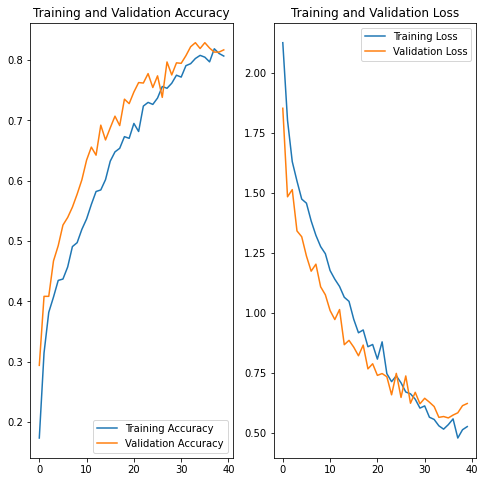

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



yes, it helped to increased the validation accuracy.